In [71]:
#Previsão de máquinas que irão falhar usando o método de regressão
# Tested with Python 3.9.13, Matplotlib 3.6.2, Scikit-learn 1.2, Seaborn 0.12.1, numpy 1.21.5, xgboost 1.7.2

#Importando bibliotecas
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import plotly.express as px
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support as score, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from sklearn.utils import compute_sample_weight
from xgboost import XGBClassifier
import xgboost as xgb
import xgboost

# Carregando os dados de treino
path = '/home/fernanda/Downloads/Desafio Ciências de Dados/'
df = pd.read_csv(path + "desafio_manutencao_preditiva_treino.csv") 

# Definindo o alvo
target_name='failure_type'

# Print do resumo dos dados de treino(10 primeiros)
print(df.shape[0])
df.head(10)

6667


,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,1,M14860,M,298.1,308.6,1551,42.8,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,No Failure
2,5,L47184,L,298.2,308.7,1408,40.0,9,No Failure
3,6,M14865,M,298.1,308.6,1425,41.9,11,No Failure
4,7,L47186,L,298.1,308.6,1558,42.4,14,No Failure
5,8,L47187,L,298.1,308.6,1527,40.2,16,No Failure
6,9,M14868,M,298.3,308.7,1667,28.6,18,No Failure
7,11,H29424,H,298.4,308.9,1782,23.9,24,No Failure
8,12,H29425,H,298.6,309.1,1423,44.3,29,No Failure
9,16,L47195,L,298.6,309.2,1542,48.4,42,No Failure


**# Limpando os dados**

In [72]:
# Procura por valores faltantes
def mss_values(df):
    null_df = pd.DataFrame(df.isna().sum(), columns=['null_values']).sort_values(['null_values'], ascending=False)
    fig = plt.subplots(figsize=(16, 6))
    ax = sns.barplot(data=null_df, x='null_values', y=null_df.index, color='royalblue')
    pct_values = [' {:g}'.format(elm) + ' ({:.1%})'.format(elm/len(df)) for elm in list(null_df['null_values'])]
    ax.set_title('Visão geral dos valores ausentes')
    ax.bar_label(container=ax.containers[0], labels=pct_values, size=12)

if df.isna().sum().sum() > 0:
    mss_values(df)
else:
    print('sem valores ausentes')

# Descarte de todas as colunas com mais de 5% de valores ausentes
for col_name in df.columns:
    if df[col_name].isna().sum()/df.shape[0] > 0.05:
        df.drop(columns=[col_name], inplace=True) 

df.columns

sem valores ausentes


Index(['udi', 'product_id', 'type', 'air_temperature_k',
       'process_temperature_k', 'rotational_speed_rpm', 'torque_nm',
       'tool_wear_min', 'failure_type'],
      dtype='object')

In [73]:
# Retirando a coluna 'product_id' e 'id'
df_base = df.drop(columns=['product_id', 'udi'])

# Ajustando o nome das colunas
df_base.rename(columns={'Air temperature [K]': 'air_temperature', 
                        'Process temperature [K]': 'process_temperature', 
                        'Rotational speed [rpm]':'rotational_speed', 
                        'Torque [Nm]': 'torque', 
                        'Tool wear [min]': 'tool_wear'}, inplace=True)
df_base.head()

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,M,298.1,308.6,1551,42.8,0,No Failure
1,L,298.2,308.7,1408,46.3,3,No Failure
2,L,298.2,308.7,1408,40.0,9,No Failure
3,M,298.1,308.6,1425,41.9,11,No Failure
4,L,298.1,308.6,1558,42.4,14,No Failure


 **# Explorando os dados**

In [74]:
# Exibição da distribuição de classe da variável de destino

px.histogram(df_base, y="failure_type", color="failure_type") 

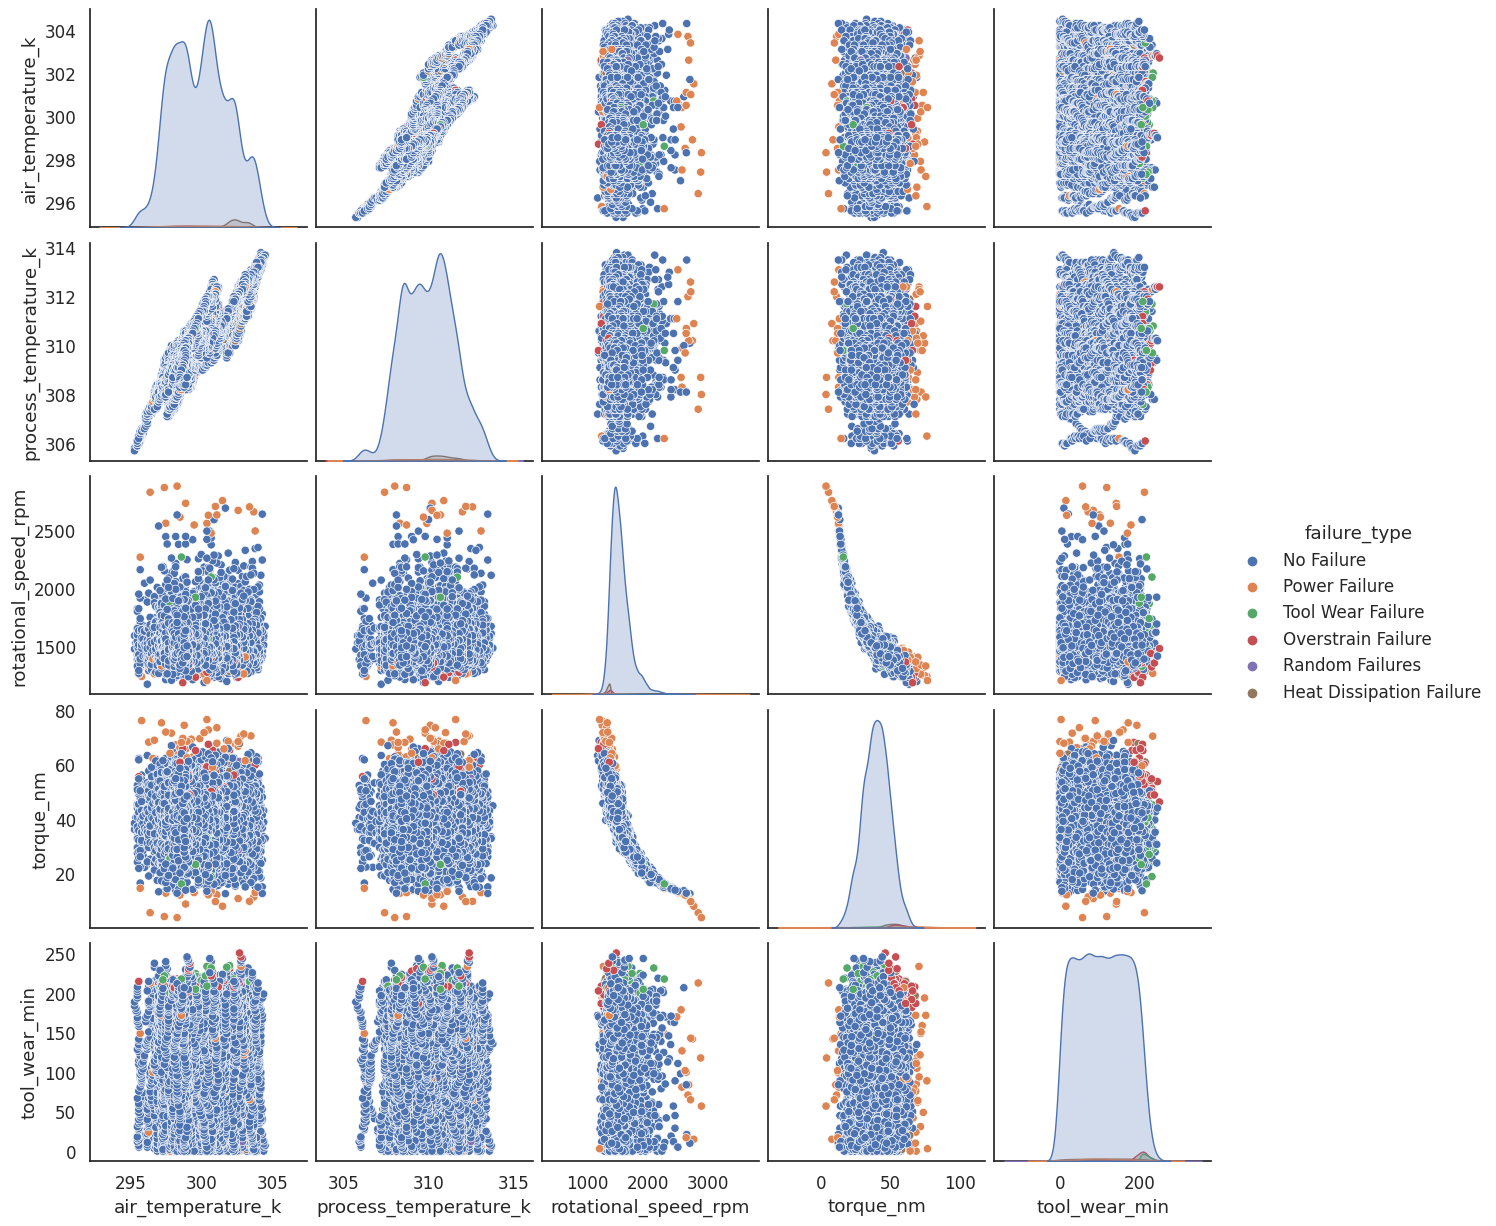

In [75]:
# Mapa de dispersão (pairplot) nos tipos de falhas
sns.pairplot(df_base, height=2.5, hue='failure_type')

/tmp/ipykernel_858/2155190466.py:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<AxesSubplot: >

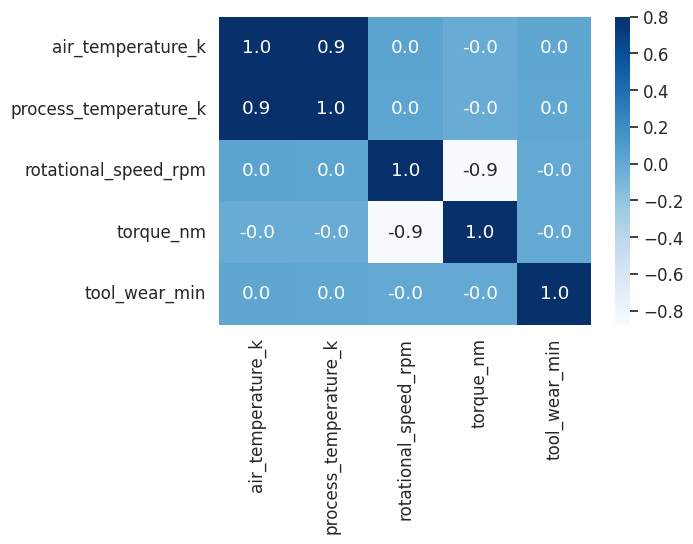

In [76]:
# Mapa de correlação
plt.figure(figsize=(6,4))
sns.heatmap(df_base.corr(), cbar=True, fmt='.1f', vmax=0.8, annot=True, cmap='Blues')

In [77]:
# Criação do histogramas para explicitar os tipos de falhas
def histogram(column_name):
    plt.figure(figsize=(16,6))
    return px.box(data_frame=df_base, y=column_name, color='failure_type', points="all", width=1200)

histogram('air_temperature_k')

<Figure size 1600x600 with 0 Axes>

In [78]:
histogram('process_temperature_k')

<Figure size 1600x600 with 0 Axes>

In [79]:
histogram('rotational_speed_rpm')

<Figure size 1600x600 with 0 Axes>

In [80]:
histogram('torque_nm')

<Figure size 1600x600 with 0 Axes>

In [81]:
histogram('tool_wear_min')

<Figure size 1600x600 with 0 Axes>

**# Preparação dos dados**

In [82]:
def preparacao_dados(df_base, target_name):
    df = df_base.dropna()

    df['target_name_encoded'] = df[target_name].replace({'No Failure': 0, 'Power Failure': 1, 'Tool Wear Failure': 2, 'Overstrain Failure': 3, 'Random Failures': 4, 'Heat Dissipation Failure': 5})
    df['type'].replace({'L': 0, 'M': 1, 'H': 2}, inplace=True)
    X = df.drop(columns=[target_name, 'target_name_encoded'])
    y = df['target_name_encoded'] #Prediction label

    # Dividindo os dados em conjuntos de dados x_train e y_train
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

    # Printando 'O resultado é:' (rows, training_sequence, features) (prediction value, )
    print('train: ', X_train.shape, y_train.shape)
    print('test: ', X_test.shape, y_test.shape)
    return X, y, X_train, X_test, y_train, y_test

# Removendo o alvo (Falilure Type) dos dados de treino e tornando ele nos dados de teste
X, y, X_train, X_test, y_train, y_test = preparacao_dados(df_base, target_name)

train:  (4666, 6) (4666,)
test:  (2001, 6) (2001,)


**# Treinando o modelo**

In [83]:
weight_train = compute_sample_weight('balanced', y_train)
weight_test = compute_sample_weight('balanced', y_test)

xgb_model = xgboost.XGBClassifier(eta=0.1, max_depth=8, 
                                    colsample_bytree=0.5, 
                                    booster='gbtree', 
                                    sampling_method='gradient_based', 
                                    eval_metric='aucpr', 
                                    objective='multi:softmax', 
                                    tree_method='hist', 
                                    num_class=6)
                                    
# Ajustando o modelo aos dados
xgb_model.fit(X_train, y_train.ravel(), sample_weight=weight_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='aucpr',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_class=6, num_parallel_tree=None, ...)

# **Avaliação do Modelo**

In [85]:
# Contagem do modelo com o conjunto de dados teste
score = xgb_model.score(X_test, y_test.ravel(), sample_weight=weight_test)

# Prevendo o conjunto de dados de teste
y_pred = xgb_model.predict(X_test)

# Print da classificação e acurácia
results_log = classification_report(y_test, y_pred)
print(results_log)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1933
           1       0.73      0.69      0.71        16
           2       0.20      0.07      0.11        14
           3       0.73      0.73      0.73        15
           4       0.00      0.00      0.00         5
           5       0.49      0.94      0.64        18

    accuracy                           0.97      2001
   macro avg       0.52      0.57      0.53      2001
weighted avg       0.97      0.97      0.97      2001



/var/data/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/var/data/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/var/data/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [86]:
# validação cruzada
val_cruzada  = cross_validate(xgb_model, X_train, y_train, cv=10, scoring="f1_weighted", fit_params={ "sample_weight" :weight_train})
val_cruzada_df = pd.DataFrame(val_cruzada)
px.bar(x=val_cruzada_df.index, y=val_cruzada_df.test_score, width=800)

/var/data/python/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 7 members, which is less than n_splits=10.



<AxesSubplot: xlabel='Predicted', ylabel='Actual'>

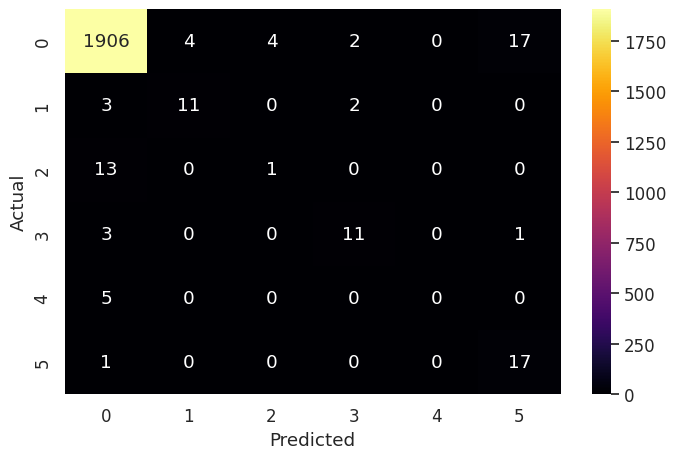

In [87]:
# Criando as previsões no conjunto de dados de teste
y_pred = xgb_model.predict(X_test)

# Print da matriz de multiclasse
matriz = confusion_matrix(y_test, y_pred)
df_matriz = pd.DataFrame(matriz, columns=np.unique(y_test), index=np.unique(y_test))
df_matriz.index.name = 'Actual'
df_matriz.columns.name = 'Predicted'
plt.figure(figsize = (8, 5))
sns.set(font_scale=1.1) #for label size
sns.heatmap(df_matriz, cbar=True, cmap= "inferno", annot=True, fmt='.0f')